In [8]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=4

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=4


In [17]:
import numpy as np
from ase import units
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from scipy.stats import linregress,t, gaussian_kde
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable


mpl.rcParams["axes.linewidth"] =  1.5
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams["xtick.major.width"] = 1.5
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["xtick.minor.width"] = 1.0
mpl.rcParams["ytick.minor.width"] = 1.0
mpl.rcParams["xtick.minor.size"] =  2.5
mpl.rcParams["ytick.minor.size"] =  2.5
mpl.rcParams["xtick.direction"] =  'in'
mpl.rcParams["ytick.direction"] =  'in'
mpl.rcParams["xtick.major.size"] =  5
mpl.rcParams["ytick.major.size"] =  5

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] ='bold'
mpl.rcParams['font.size'] = 12.0
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

markers = ['o', 'v', '^', 's', 'd', 'X', "P", "*"]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

%matplotlib inline

In [13]:

def apply_kwargs(ax, x, y, kwargs):
    if kwargs is None:
        ax.plot(x, y)
    else:
        ax.plot(x, y, **kwargs)

def set_ticks(ax, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 5):
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
    if xlinear: ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(xticks))
    if xmax: ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(xticks))
    if ylinear: ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(yticks))
    if ymax: ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(yticks))



def plot_rdf(directory, ax, plot_one = True, kwargs = None):
    x = np.load(f"{directory}/xbins.npy")
    y = np.load(f"{directory}/rdf.npy")
    if plot_one: ax.hlines(xmin=0, xmax=x[-1], y=1.0, color="k", linestyles=':')
    apply_kwargs(ax, x, y, kwargs) 


def plot_ni(directory, ax, kwargs = None):
    x = np.load(f"{directory}/xbins.npy")
    y = np.load(f"{directory}/number_integral.npy")   
    apply_kwargs(ax, x, y, kwargs) 

def plot_volume(directory, ax, timestep=None, kwargs = None):
    y = np.load(f"{directory}/volume.npy")
    if timestep is None:
        x = np.arange(0, len(y))
    else:
        x = np.arange(0, len(y)) * timestep
    apply_kwargs(ax, x, y, kwargs) 


def plot_density(directory, ax, timestep=None, kwargs = None):
    y = np.load(f"{directory}/density_kgperm3.npy")
    half = len(y)//2
    rho_avg = np.mean(y[half:])
    rho_std = np.std(y[half:])
    print(f"Density (kg/m3) = {rho_avg:.3f} +/- {rho_std:.3f}")
    if timestep is None:
        x = np.arange(0, len(y))
    else:
        x = np.arange(0, len(y)) * timestep
    apply_kwargs(ax, x, y, kwargs) 

def confidence_interval(x, res):
    # Two-sided inverse Students t-distribution
    # p - probability, df - degrees of freedom
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    slope_confidence = ts * res.stderr
    intercept_confidence = ts * res.intercept_stderr
    return slope_confidence, intercept_confidence


def linregress_with_ci(x, y):
    res = linregress(x, y)
    slope = res.slope
    intercept = res.intercept
    r2 = res.rvalue**2
    slope_ci, intercept_ci = confidence_interval(x, res)
    return slope, intercept, r2, slope_ci, intercept_ci


def plot_parity(directory, axs, hartree = False, aspect_equal = True, legend = True, labels = True, plot_title = True, 
                symbols = { "O": ["s", "blue"], "H": ["v", "orange"], "Si": ["o", "red"], "C": ["^", "green"], "Sn": ["*", "yellow"],}):
    
    energy_correlation = np.load(f"{directory}/energy_correlation.npy")
    force_correlation = {}
    for key, value in symbols.items():
        force_correlation[key] = np.load(f"{directory}/{key}_force_correlation.npy")
        
    for ax, correlation, title in zip(axs, [energy_correlation, force_correlation],['Energy (eV)','Force (eV/Å)']):
    
        if title != "Force (eV/Å)":
            if hartree:
                correlation /= units.Ha
                title = 'Energy (Ha)' 

            x = correlation[:,0]
            y = correlation[:,1]
                
            ax.scatter(x,y, s = 48, edgecolors = "k")
            R_square = r2_score(x, y) 
            print(f" {title} $R^2$ = {R_square}")

        else:
            for element, value in symbols.items():
                x = correlation[element][:,0]
                y = correlation[element][:,1]
                
                if labels:
                    ax.scatter(x,y, label = element, marker = value[0], c = value[1], s =48, edgecolors = 'k')

                else:
                    ax.scatter(x,y, marker = value[0], c = value[1], s =48, edgecolors = 'k')

                R_square = r2_score(x, y) 
            
                print(f" {title} {element} $R^2$ = {R_square}")

            if legend: ax.legend()

        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]), 
            np.max([ax.get_xlim(), ax.get_ylim()]),  
        ]

        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

        if aspect_equal: ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        if plot_title: ax.set_title(title, fontweight="bold")


def plot_distribution(ax, x, y, z, square=False, hexbin=False):
    idx = z.argsort()
    if hexbin:
        mappable = plt.hexbin(x, y, gridsize=30, bins="log", cmap="plasma")
    else:
        mappable = ax.scatter(x[idx], y[idx], c=z[idx], s=20)

    pmin = min(np.min(x), np.min(y))
    pmax = max(np.max(x), np.max(y))
    if square:
        ax.plot((pmin, pmax), (pmin, pmax), color="red")
        pmin = min(np.min(x), np.min(y))
        pmax = max(np.max(x), np.max(y))
        ax.set_xticks(ax.get_yticks())
        ax.set_xlim(pmin, pmax)
        ax.set_ylim(pmin, pmax)
    else:
        ax.plot((np.min(x), np.max(x)), (0, 0), color="red")
        ax.set_xlim(np.min(x), np.max(x))
        ax.set_ylim(np.min(y), np.max(y))
        #ax.set_box_aspect(1)
    return mappable 


def unit_vector(vector):
    return vector / np.linalg.norm(vector) 

def angle_between_vectors(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    value = np.arccos(np.clip(np.dot(v1_u, v2_u), -1, 1))
    if np.isnan(value):
        return -1
    else:
        return value

def label_mosaic_subplot(axs):
    for label, ax in axs.items():
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
        ax.annotate(
            label,
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
            )

'''
fig, axs = plt.subplots(
    nrows = 1, ncols = 2, 
    figsize=(6.5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )

axs[0][0].text(
        0.1, 0.85,
        f"a)",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs[0][0].transAxes,
    )

fig.legend(loc = "outside lower center", ncols = 5, columnspacing = 1.0, handletextpad=0.4)
'''
pass

# Parity

 Energy (eV) $R^2$ = 0.9997078272449422
 Force (eV/Å) Cs $R^2$ = 0.9989037498901644
 Force (eV/Å) Na $R^2$ = 0.9991944435268213
 Force (eV/Å) In $R^2$ = 0.9994548809067503
 Force (eV/Å) Cl $R^2$ = 0.9992610569613168
 Force (eV/Å) Sb $R^2$ = 0.9978679208988289


Text(0, 0.5, 'MACE')

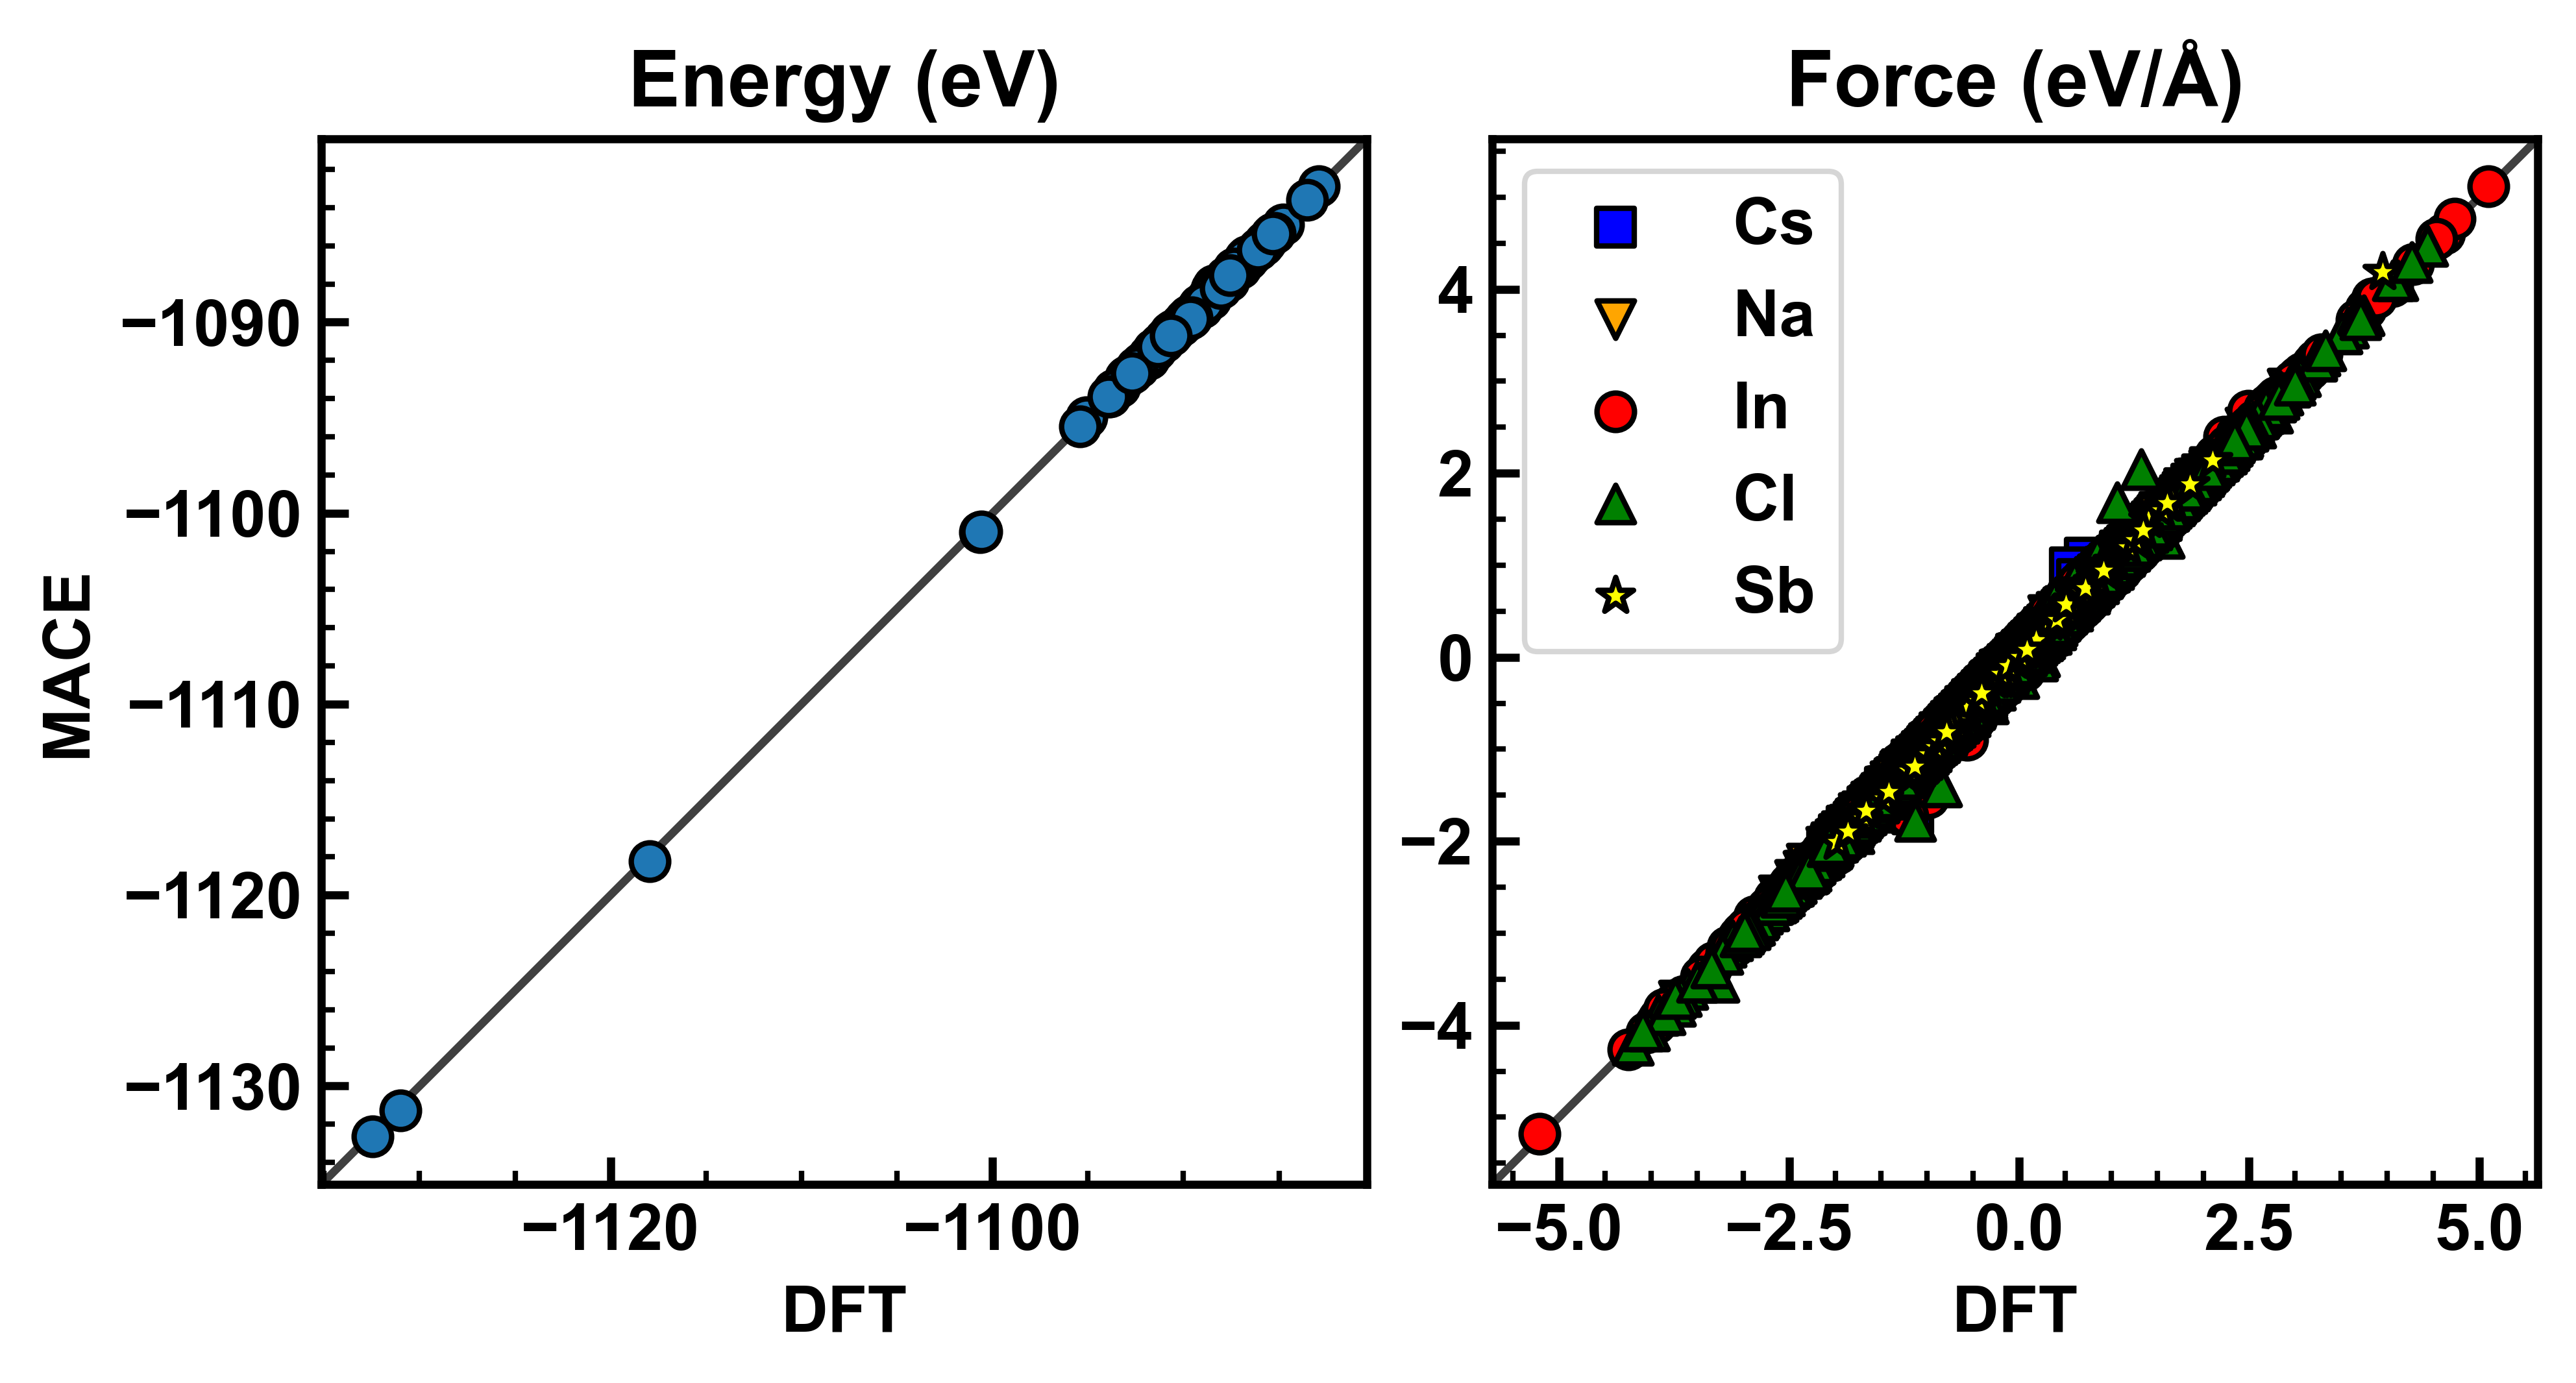

In [18]:


fig, axs = plt.subplot_mosaic(
    [['a)', 'b)']],
    figsize=(6.5, 3.5), dpi=600, sharex = False, sharey = False, layout='constrained'
)

plot_parity("../mlip/Cs2NaInCl6/N2_v3_r6_l1_f128", [axs['a)'], axs['b)']], hartree = False, aspect_equal = True, legend = True, labels = True, plot_title = True, 
                symbols = { "Cs": ["s", "blue"], "Na": ["v", "orange"], "In": ["o", "red"], "Cl": ["^", "green"], "Sb": ["*", "yellow"],})

axs['a)'].set_xlabel("DFT")
axs['b)'].set_xlabel("DFT")
axs['a)'].set_ylabel("MACE")



Calculating Angle Error...


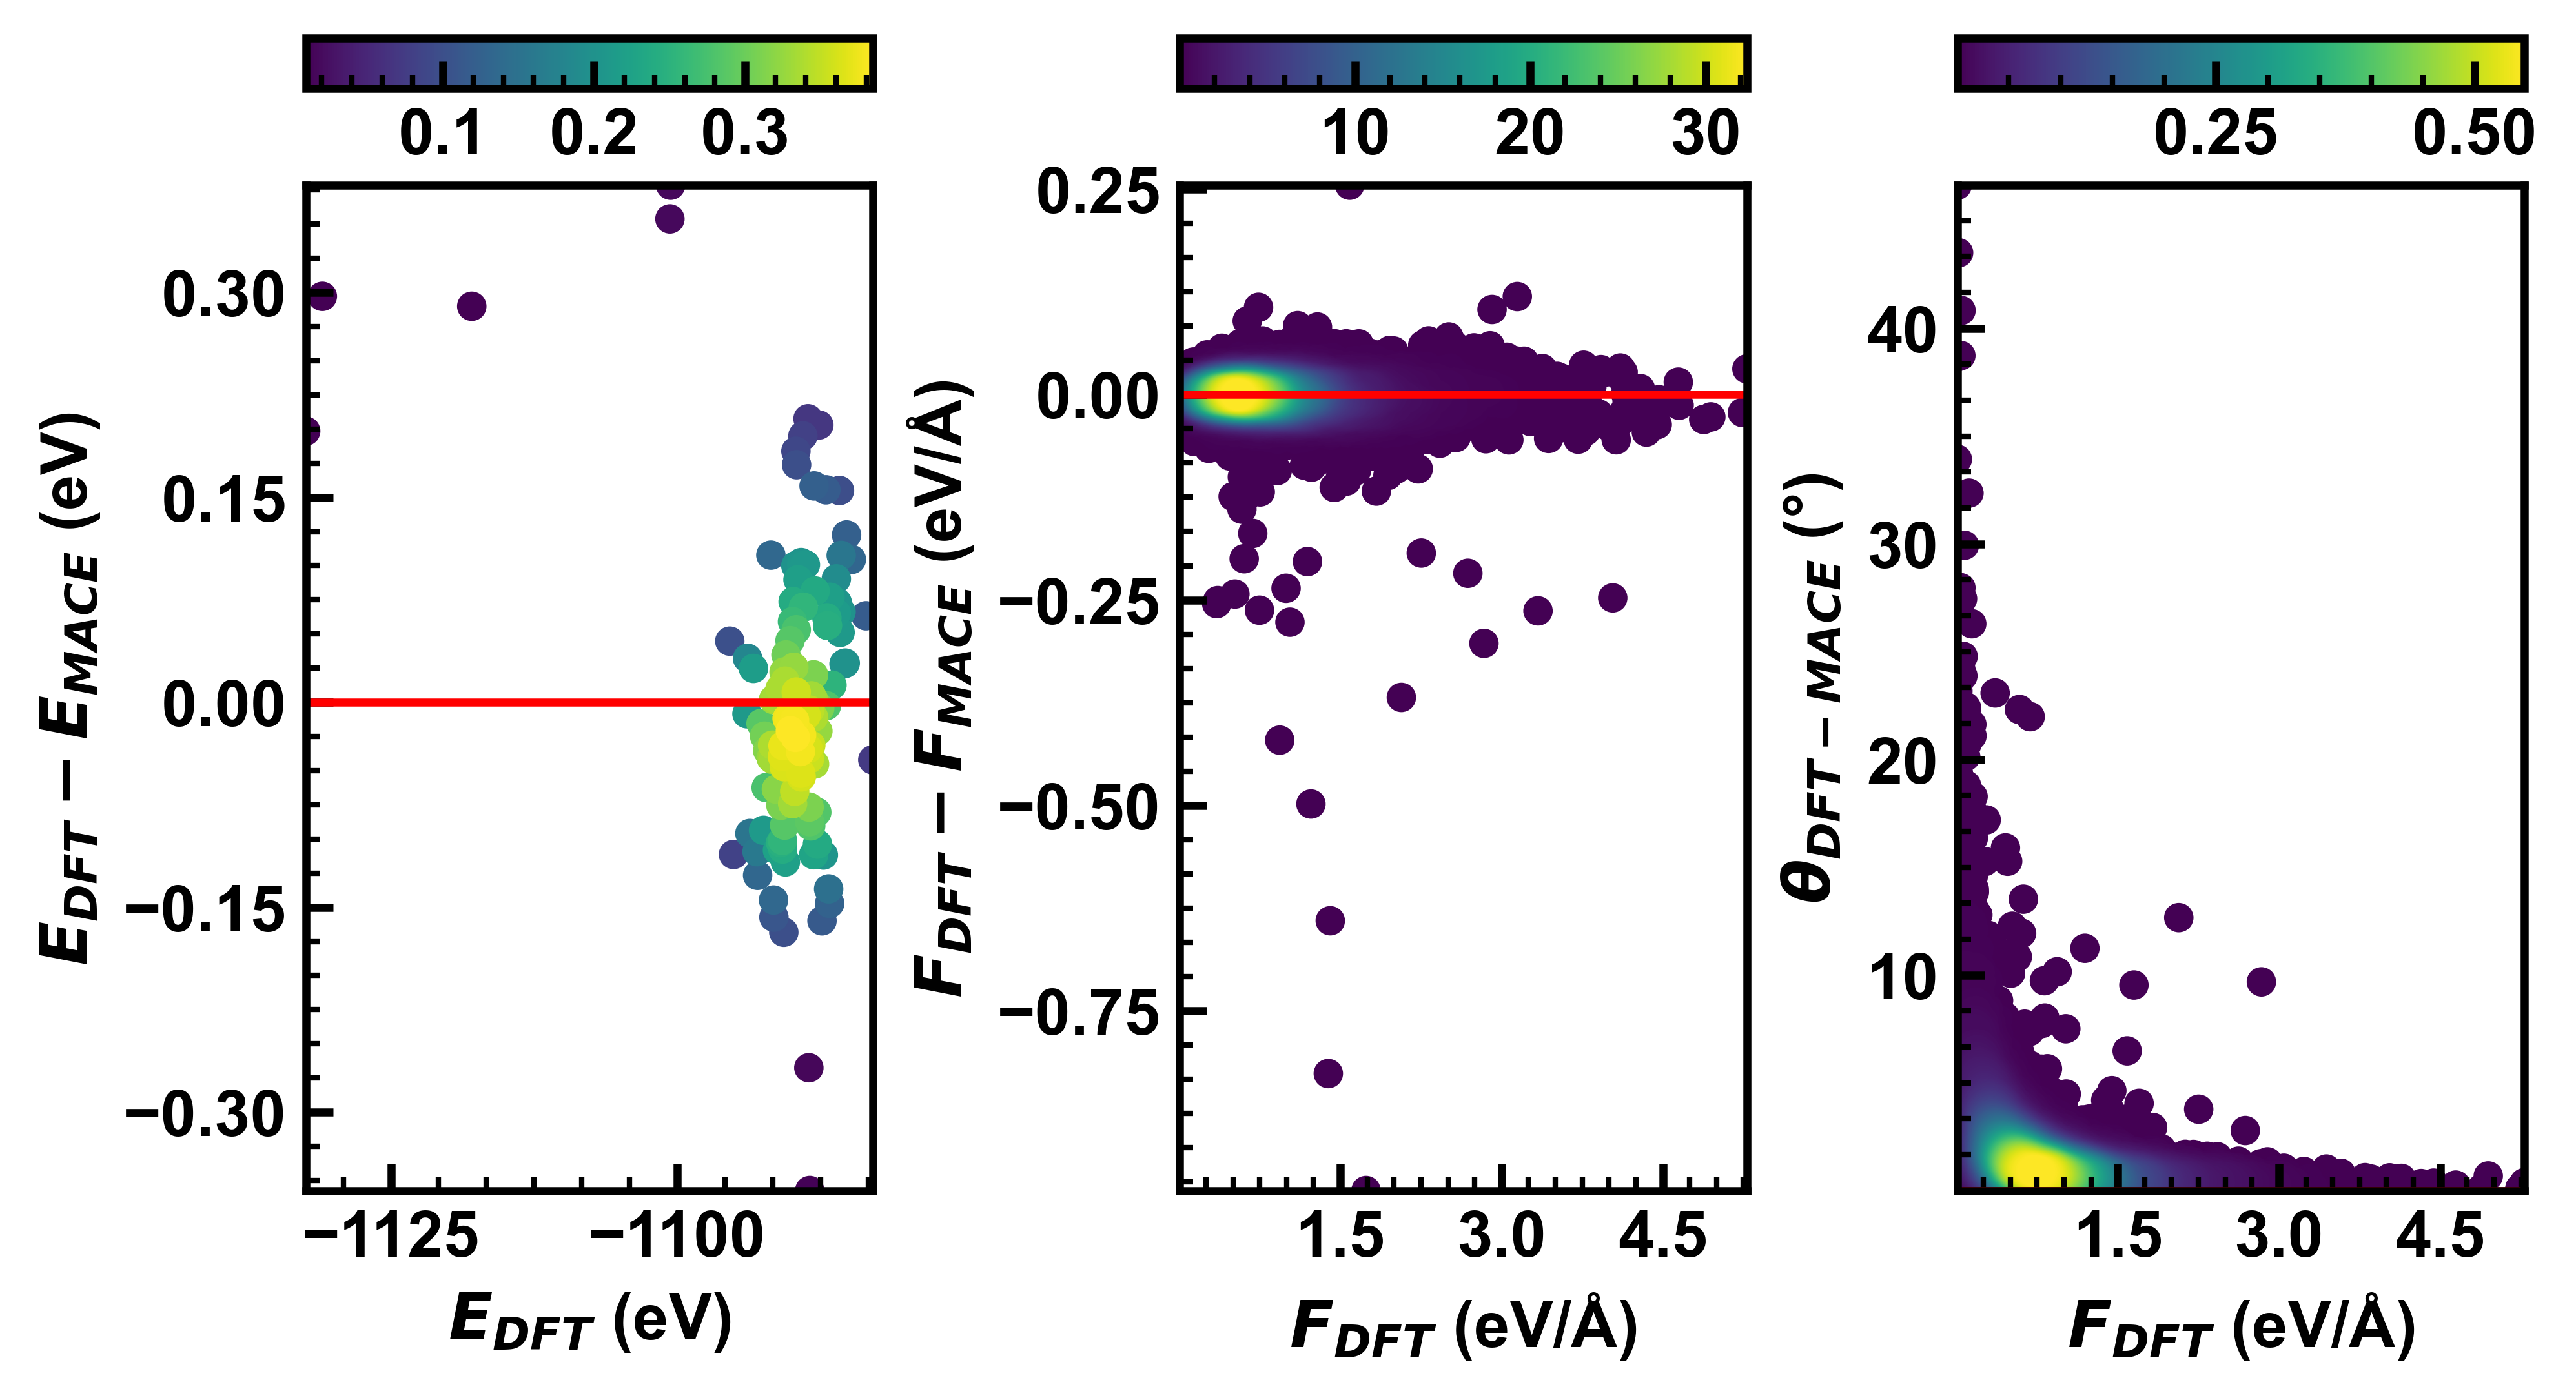

In [23]:
fig, axs = plt.subplot_mosaic(
    [['a)', 'b)', 'c)']],
    figsize=(6.5, 3.5), dpi=600, sharex = False, sharey = False, layout='constrained'
)

energy_correlation = np.load("../mlip/Cs2NaInCl6/N2_v3_r6_l1_f128/energy_correlation_peratom.npy") 
dft_energy = energy_correlation[:,0]
nn_energy = energy_correlation[:,1] 

dft_force = np.load('../mlip/Cs2NaInCl6/N2_v3_r6_l1_f128/dft_forces.npy')
nn_force = np.load('../mlip/Cs2NaInCl6/N2_v3_r6_l1_f128/nn_forces.npy')

dft_force_mag = np.linalg.norm(dft_force, axis=1)
nn_force_mag = np.linalg.norm(nn_force, axis=1)

print("Calculating Angle Error...")
angle_error = np.zeros(dft_force_mag.shape)
for index in range(len(dft_force_mag)):
    angle_error[index] = angle_between_vectors(dft_force[index], nn_force[index]) / np.pi * 180 


mappable1 = plot_distribution(axs['a)'], dft_energy, dft_energy - nn_energy, 
                              np.load('../mlip/Cs2NaInCl6/N2_v3_r6_l1_f128/gkde-energy_residuals.npy'), square=False, hexbin=False)
divider = make_axes_locatable(axs['a)'])
cax1 = divider.append_axes('top', size='5%', pad=0.25)
fig.colorbar(mappable1, cax=cax1, orientation='horizontal')

mappable2 = plot_distribution(axs['b)'], dft_force_mag, dft_force_mag - nn_force_mag, 
                              np.load('../mlip/Cs2NaInCl6/N2_v3_r6_l1_f128/gkde-force_residuals.npy'),
                              square=False, hexbin=False)
divider = make_axes_locatable(axs['b)'])
cax2 = divider.append_axes('top', size='5%', pad=0.25)
fig.colorbar(mappable2, cax=cax2, orientation='horizontal')

mappable3 = plot_distribution(axs['c)'], dft_force_mag, angle_error, 
                              np.load('../mlip/Cs2NaInCl6/N2_v3_r6_l1_f128/gkde-force_angle.npy'),
                              square=False, hexbin=False)
divider = make_axes_locatable(axs['c)'])
cax3 = divider.append_axes('top', size='5%', pad=0.25)
fig.colorbar(mappable3, cax=cax3, orientation='horizontal')


set_ticks(axs['a)'], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 2)
set_ticks(axs['b)'], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)
set_ticks(axs['c)'], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)

axs['a)'].set_xlabel("$E_{DFT}$ (eV)")
axs['a)'].set_ylabel("$E_{DFT} - E_{MACE}$ (eV)")

axs['b)'].set_xlabel("$F_{DFT}$ (eV/Å)")
axs['b)'].set_ylabel("$F_{DFT} - F_{MACE}$ (eV/Å)")

axs['c)'].set_xlabel("$F_{DFT}$ (eV/Å)")
axs['c)'].set_ylabel(r"$\theta_{DFT-MACE}$ (°)")





fig.savefig('Cs2NaInCl6-residuals.png')
fig.savefig('Cs2NaInCl6-residuals.tiff')
fig.savefig('Cs2NaInCl6-residuals.eps')
fig.savefig('Cs2NaInCl6-residuals.pdf')

